In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Data preprocessing
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Convolutional neural network
from keras.models import Sequential
from tensorflow.keras import layers, models

# helper functions
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model


2025-08-17 05:30:12.687799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755408612.701172       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755408612.705197       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-17 05:30:12.722134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io

In [3]:
# Print list of files and directories in folder
input_dir = '/kaggle/input/histopathologic-cancer-detection'
list_l = [os.path.join(input_dir, x) for x in os.listdir(input_dir)]
list_l


['/kaggle/input/histopathologic-cancer-detection/description.md',
 '/kaggle/input/histopathologic-cancer-detection/test',
 '/kaggle/input/histopathologic-cancer-detection/train',
 '/kaggle/input/histopathologic-cancer-detection/test.zip',
 '/kaggle/input/histopathologic-cancer-detection/train.zip',
 '/kaggle/input/histopathologic-cancer-detection/train_labels.csv',
 '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv.zip',
 '/kaggle/input/histopathologic-cancer-detection/train_labels.csv.zip',
 '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv',
 '/kaggle/input/histopathologic-cancer-detection/histopathologic-cancer-detection']

In [4]:
# Set datasets and directory names
sample_data = pd.read_csv(list_l[0])
train_data = pd.read_csv(list_l[1])
train_dir = list_l[3] + '/'
test_dir = list_l[2] + '/'


ParserError: Error tokenizing data. C error: Expected 1 fields in line 7, saw 4


In [5]:
# Cleaning
del list_l


In [6]:
def print_short_summary(name, data):
    """
    Prints data head, shape and info.
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()
    
def print_number_files(dirpath):
    print('{}: {} files'.format(dirpath, len(os.listdir(dirpath))))


In [7]:
print_short_summary('Train data', train_data)


NameError: name 'train_data' is not defined

In [8]:
print_short_summary('Sample data', sample_data)


NameError: name 'sample_data' is not defined

In [9]:
print_number_files(train_dir)


NameError: name 'train_dir' is not defined

In [10]:
print_number_files(test_dir)


NameError: name 'test_dir' is not defined

In [11]:
# Cleaning
del print_short_summary, print_number_files


In [12]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data['label'].value_counts()
sns.barplot(y=['No Cancer', 'Cancer'], x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Label')
plt.title('Number of records per label')
plt.show()


NameError: name 'train_data' is not defined

<Figure size 1600x900 with 0 Axes>

In [13]:
# Cleaning
del tmp


NameError: name 'tmp' is not defined

In [14]:
def get_images_to_plot(file_names):
    """
    Returns list of images
    Args:
        file_names: list of filenames
    Returns:
        list of image objects
    """
    return [Image.open(f) for f in file_names]

def get_image_label(dirname, data, labels, n = 5):
    """
    Return dictionary with label-imagepath
    Args:
        dirname: name of the directory
        data: dataset of file names
        labels: list of labels
        n (opt): number of images per label
    Returns:
        dict_img: dictionary with label-imagepath pairs
    """
    dict_img = {}
    for l in labels:
        indexes = data['label'] == l
        tmp = data[indexes][:n]
        tmp = dirname + tmp['id'] + '.tif'
        tmp = tmp.values
        tmp = get_images_to_plot(tmp)
        dict_img[l] = tmp
        
    return dict_img


In [15]:
# Print original image size
img_path = train_dir + train_data['id'][0] + '.tif'
img = Image.open(img_path)
print('Original image size: {}'.format(img.size))


NameError: name 'train_dir' is not defined

In [16]:
# Get 5 filenames per label
data = get_image_label(train_dir,train_data, [0,1])


NameError: name 'train_dir' is not defined

NameError: name 'data' is not defined

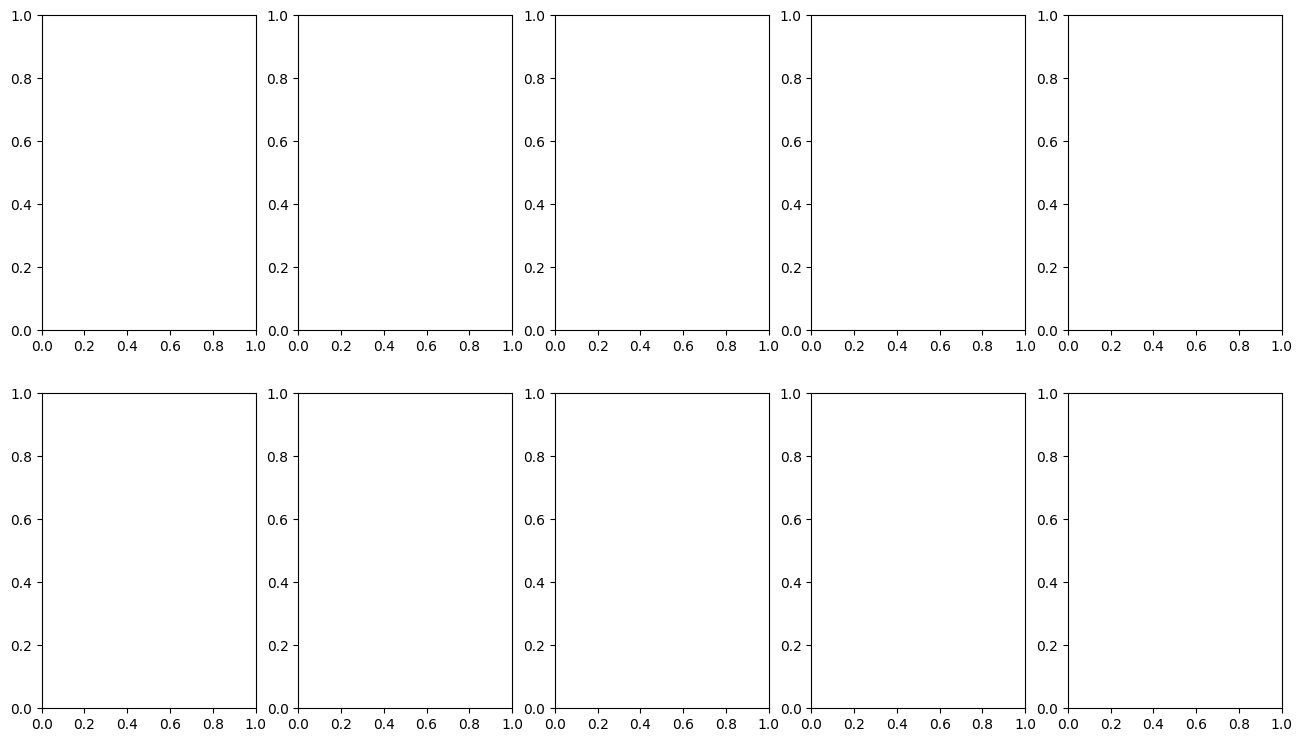

In [17]:
# Initialize subplots with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))

# Loop through selected images and display in the respective rows
labels = ['No Cancer', 'Cancer']
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(data[row][col])
    axes[row, col].set_title(labels[row])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [18]:
# Cleaning
del get_images_to_plot, get_image_label, img_path, img
del data, fig, axes, labels, row, col


NameError: name 'img_path' is not defined

In [19]:
# Majority class
no_cancer = train_data[train_data['label'] == 0]
# Minority class
cancer = train_data[train_data['label'] == 1]

# Downsample majority class to match minority class
no_cancer_downsampled = resample(no_cancer,
                              replace=False, 
                              n_samples=len(cancer),
                              random_state=0)

balanced_train_data = pd.concat([no_cancer_downsampled, cancer])

# Shuffle train data for training
balanced_train_data = balanced_train_data.sample(frac=1, random_state=0).reset_index(drop=True)


NameError: name 'train_data' is not defined

In [20]:
# Cleaning
del no_cancer, cancer, no_cancer_downsampled


NameError: name 'no_cancer' is not defined

In [21]:
# Get full path to image including extension
image_paths = train_dir + balanced_train_data['id'] + '.tif'
image_paths = image_paths.values

labels = balanced_train_data['label'].values

X_train, X_test, y_train, y_test = train_test_split(image_paths
                                                    , labels
                                                    , test_size = 0.25
                                                    , shuffle = True
                                                    , random_state = 0)


NameError: name 'train_dir' is not defined

In [22]:
# Cleaning
del image_paths, labels


NameError: name 'image_paths' is not defined

In [23]:
def get_decoded_image(image_path, label=None):
    """
    Load and preprocess images using TensorFlow I/O.
    Decode image with 4 channels RGBA.
    Resize image to 32x32px.
    Scale pixels from 0 to 1.
    Args:
        image_path: path to TIFF image
        label (optional): true label from train data
    Returns:
        (img, label): for train data
        img: for test data
    """
    img = tf.io.read_file(image_path)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.resize(img, [32, 32])
    img = tf.cast(img, tf.float32) / 255.0
    
    return img if label is None else (img, label)

def get_prefetched_data(data, batch_size):
    """
    Create a TensorFlow dataset from image paths and labels.
    Execution in parallel.
    Load, preprocess images and batch the data.
    Prefetch batches to improve training performance.
    Args:
        data (tuple): image paths and corresponding labels
        batch_size (int): number of samples per batch
    Returns:
        tf.data.Dataset: preprocessed and preloaded TensorFlow dataset for keras CNN
    """
    # Autotune the degree of parallelism during training
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    # Create dataset from image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Apply parallel processing to load and preprocess images
    dataset = dataset.map(get_decoded_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset


In [24]:
# Set 128 samples to be processed in each training step
BATCH_SIZE = 128

train_dataset = get_prefetched_data((X_train, y_train)
                                    , BATCH_SIZE)
test_dataset = get_prefetched_data((X_test, y_test)
                                   , BATCH_SIZE)


NameError: name 'X_train' is not defined

In [25]:
del X_train, y_train, X_test, y_test


NameError: name 'X_train' is not defined

In [26]:
def get_model_base():
    """
    Return base model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))

        , layers.Flatten()

        , layers.Dense(32, activation='relu')

        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [27]:
def get_model_base_deep():
    """
    Return deeper model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))
        # Add new convolutional layer
        , layers.Conv2D(32, (3, 3), activation='relu')

        , layers.Flatten()

        , layers.Dense(32, activation='relu')
        # Add new dense layer
        , layers.Dense(32, activation='relu')

        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [28]:
def get_model_base_wide():
    """
    Return wider model architecture
    """
    model_drop_bn = models.Sequential([
        # Increase number of units from 32 to 64
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 4))

        , layers.Flatten()
        
        # Increase number of units from 32 to 64
        , layers.Dense(64, activation='relu')
 
        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model_drop_bn


In [29]:
def get_model_base_maxpool():
    """
    Return maxpool model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))
        # Add new layer of max pooling
        , layers.MaxPooling2D((2, 2), strides = (2,2))

        , layers.Flatten()

        , layers.Dense(32, activation='relu')
        
        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [30]:
def get_model_base_dropout():
    """
    Return dropout model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))

        , layers.Flatten()

        , layers.Dense(32, activation='relu')
        
        # Add new dropout layer 
        , layers.Dropout(0.25)
        
        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [31]:
def get_compiled_model(func):
    """
    Create model to be trained with a multi-GPU strategy.
    Args:
        func: function to get model architecture
    Returns:
        compiled_model: tensorflow model that performs data parallelism
                            by copying all of the model's variables
                            to each processor
    """
    # Check if GPU is available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Create a MirroredStrategy.
        strategy = tf.distribute.MirroredStrategy()

        print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
        print('No GPU available, falling back to CPU.')

    with strategy.scope():
        compiled_model = func()
        compiled_model.compile(optimizer = tf.keras.optimizers.Adam()
                              , loss = tf.keras.losses.BinaryCrossentropy()
                              , metrics = [tf.keras.metrics.AUC()])

    return compiled_model


In [32]:
def plot_model_scores(scores, model_name):
    """
    Plot train and test ROC AUC scores of a model by epoch
    """
    train_scores, test_scores = scores
    epochs = range(1, len(train_scores) + 1)

    # Plot train and test scores
    plt.figure(figsize=(16, 9))
    plt.plot(epochs, train_scores, label='Train score')
    plt.plot(epochs, test_scores, label='Test score')
    plt.title('Train and test ROC AUC scores of the {}'.format(model_name))
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    
def get_model_results(model_name, model):
    """
    Return tuple of runtime, train and test scores.
    Compile, fit and save model along the way.
    Args:
        model: fitted model
    Returns:
        (runtime, (train_scores, test_scores) )
    """
    model = get_compiled_model(model)
    
    st = time.time()
    model.fit(train_dataset, epochs=5, validation_data=test_dataset)
    runtime = time.time() - st
    
    model.save('{}.h5'.format(model_name))
    
    train_scores = model.history.history['auc']
    test_scores = model.history.history['val_auc']
    
    tf.keras.backend.clear_session()
    
    return (runtime, (train_scores, test_scores))


In [33]:
# Get train and test scores of every epoch
runtime_base, scores_base = get_model_results('model_base',get_model_base)


No GPU available, falling back to CPU.


2025-08-17 05:30:19.465924: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'train_dataset' is not defined

In [34]:
# Plot scores
plot_model_scores(scores_base, 'base model')


NameError: name 'scores_base' is not defined

In [35]:
# Get train and test scores of every epoch
runtime_base_deep, scores_base_deep = get_model_results('model_base_deep'
                                                          ,get_model_base_deep)


No GPU available, falling back to CPU.


NameError: name 'train_dataset' is not defined

In [36]:
# Plot scores
plot_model_scores(scores_base_deep, 'base + additional layers model')


NameError: name 'scores_base_deep' is not defined

In [37]:
# Get train and test scores of every epoch
runtime_base_wide, scores_base_wide = get_model_results('model_base_wide'
                                                          ,get_model_base_wide)


No GPU available, falling back to CPU.


NameError: name 'train_dataset' is not defined

In [38]:
# Plot scores
plot_model_scores(scores_base_wide, 'base + wider layers model')


NameError: name 'scores_base_wide' is not defined

In [39]:
# Get train and test scores of every epoch
runtime_base_maxpool, scores_base_maxpool = get_model_results('model_base_maxpool'
                                                                ,get_model_base_maxpool)


No GPU available, falling back to CPU.


NameError: name 'train_dataset' is not defined

In [40]:
# Plot scores
plot_model_scores(scores_base_maxpool, 'base + max pooling model')


NameError: name 'scores_base_maxpool' is not defined

In [41]:
# Get train and test scores of every epoch
runtime_base_dropout, scores_base_dropout = get_model_results('model_base_dropout'
                                                                ,get_model_base_dropout)


No GPU available, falling back to CPU.


NameError: name 'train_dataset' is not defined

In [42]:
# Plot scores
plot_model_scores(scores_base_dropout, 'base + dropout model')


NameError: name 'scores_base_dropout' is not defined

In [43]:
# Print table results comparison
results = [('Base', runtime_base, scores_base)
          ,('Base + Add. layers', runtime_base_deep, scores_base_deep)
          ,('Base + Wider layers', runtime_base_wide, scores_base_wide)
          ,('Base + Max pooling', runtime_base_maxpool, scores_base_maxpool)
          ,('Base + Dropout', runtime_base_dropout, scores_base_dropout)]
table = []
for i in range(len(results)):
    tmp = {
            'model': results[i][0]
            , 'runtime (sec)': results[i][1]
            , 'train_roc_auc_score': results[i][2][0][-1]
            , 'test_roc_auc_score': results[i][2][1][-1]
        }
    table.append(tmp)


pd.DataFrame(table).sort_values(by = ['test_roc_auc_score'
                                      ,'runtime (sec)']
                                , ascending = [False, True])


NameError: name 'runtime_base' is not defined

In [44]:
# Cleaning
del results, tmp, table, train_dataset, test_dataset, train_data, train_dir, test_dir
del get_model_results, plot_model_scores, get_compiled_model


NameError: name 'results' is not defined

In [45]:
# Load top performed model
model = load_model('model_base_deep.h5')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model_base_deep.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [46]:
# Create prefethed dataset of images to classify
submis_data = test_dir + sample_data['id'] + '.tif'
submis_data = submis_data.values

submis_dataset = get_prefetched_data((submis_data)
                                    , BATCH_SIZE)


NameError: name 'test_dir' is not defined

In [47]:
# Set results
results = model.predict(submis_dataset)


NameError: name 'model' is not defined

In [48]:
# Create table of ids and labels like sample_submission
sample_data['label'] = np.ravel(np.round(results))


NameError: name 'results' is not defined

In [49]:
# Print submission table
sample_data


NameError: name 'sample_data' is not defined

In [50]:
# Make submission
sample_data.to_csv('submission.csv', index=False)


NameError: name 'sample_data' is not defined

In [51]:
# Cleaning
del submis_data, submis_dataset, sample_data
del get_decoded_image, get_prefetched_data


NameError: name 'submis_data' is not defined